In [1]:
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchinfo import summary
import cv2
import matplotlib.pyplot as plt
from deepmag import dataset, viz, model, train

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

/home/rhijn/VMM-real-time/motion-magnification-master/deepmag/train.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
torch.cuda.get_device_name()

'Orin'

In [3]:
m = torch.load('data/models/20191202-b10-r0.1-lr0.0001-00.pt').to(device).eval()

/usr/local/lib/python3.8/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.padding.ReflectionPad2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute

In [4]:
summary(m, input_size=((1, 3, 544, 960), (1, 3, 544, 960), (1,1)), device='cuda:0')

Layer (type:depth-idx)                             Output Shape              Param #
MagNet                                             [1, 3, 544, 960]          --
├─Encoder: 1-1                                     [1, 32, 136, 240]         --
│    └─Sequential: 2-1                             [1, 32, 272, 480]         --
│    │    └─ReflectionPad2d: 3-1                   [1, 3, 550, 966]          --
│    │    └─Conv2d: 3-2                            [1, 16, 544, 960]         2,368
│    │    └─ReLU: 3-3                              [1, 16, 544, 960]         --
│    │    └─ReflectionPad2d: 3-4                   [1, 16, 546, 962]         --
│    │    └─Conv2d: 3-5                            [1, 32, 272, 480]         4,640
│    │    └─ReLU: 3-6                              [1, 32, 272, 480]         --
│    └─Sequential: 2-2                             [1, 32, 272, 480]         --
│    │    └─ResidualBlock: 3-7                     [1, 32, 272, 480]         18,496
│    │    └─ResidualBlock

In [5]:
import numpy as np
import time
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [6]:
def benchmark(model, input_shape=((1, 3, 544, 960), (1, 3, 544, 960), (1,1)), dtype='fp32', nwarmup=50, nruns=10000):
    input_data_0 = torch.randn(input_shape[0])
    input_data_0 = input_data_0.to(device)
    input_data_1 = torch.randn(input_shape[1])
    input_data_1 = input_data_1.to(device)
    input_data_2 = torch.randn(input_shape[2])
    input_data_2 = input_data_2.to(device)
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            pred, _, _ = model.forward(input_data_0, input_data_1, input_data_2)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred, _, _ = model.forward(input_data_0, input_data_1, input_data_2)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_shape)
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [7]:
benchmark(m, input_shape=((1, 3, 544, 960), (1, 3, 544, 960), (1,1)), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 590.27 ms
Iteration 20/100, ave batch time 558.51 ms
Iteration 30/100, ave batch time 546.78 ms
Iteration 40/100, ave batch time 541.91 ms
Iteration 50/100, ave batch time 538.78 ms
Iteration 60/100, ave batch time 536.60 ms
Iteration 70/100, ave batch time 536.60 ms
Iteration 80/100, ave batch time 540.36 ms
Iteration 90/100, ave batch time 546.40 ms
Iteration 100/100, ave batch time 552.79 ms
Input shape: ((1, 3, 544, 960), (1, 3, 544, 960), (1, 1))
Average batch time: 552.79 ms


In [6]:
example_input_0 = torch.randn((1, 3, 544, 960)).to(device)
example_input_1 = torch.randn((1, 3, 544, 960)).to(device)
example_input_2 = torch.randn((1, 1)).to(device)

model_traced = torch.jit.trace(m, (example_input_0, example_input_1, example_input_2))

/home/rhijn/VMM-real-time/motion-magnification-master/deepmag/model.py:63: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  amp = amp_f.reshape(len(amp_f), 1, 1, 1)


In [4]:
import torch_tensorrt

In [5]:
torch.cuda.empty_cache()

In [7]:
# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
trt_model_fp32 = torch_tensorrt.compile(model_traced, inputs = [example_input_0, example_input_1, example_input_2],
    enabled_precisions = torch.float32, # Run with FP32
    workspace_size = 1 << 22
)

# torch_tensorrt.Input(example_input_0, dtype=torch.float32), torch_tensorrt.Input(example_input_2, dtype=torch.float32), torch_tensorrt.Input(example_input_2, dtype=torch.float32)

ERROR: [Torch-TensorRT TorchScript Conversion Context] - 4: [optimizer.cpp::computeCosts::3725] Error Code 4: Internal Error (Could not find any implementation for node {ForeignNode[%input.57 : Tensor = aten::add(%input.47, %y.7, %9), scope: __module.encoder/__module.encoder.texture/__module.encoder.texture.3 # /home/rhijn/VMM-real-time/motion-magnification-master/deepmag/model.py:112:0...(Unnamed Layer* 837) [Concatenation]]} due to insufficient workspace. See verbose log for requested sizes.)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [builder.cpp::buildSerializedNetwork::751] Error Code 2: Internal Error (Assertion engine != nullptr failed. )


RuntimeError: [Error thrown at core/conversion/conversionctx/ConversionCtx.cpp:169] Building serialized network failed in TensorRT


In [12]:
torch.jit.save(trt_model_fp32, "trt_script_module.ts")

In [13]:
benchmark(trt_model_fp32, input_shape=((1, 3, 544, 960), (1, 3, 544, 960), (1,1)), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 343.85 ms
Iteration 20/100, ave batch time 344.98 ms
Iteration 30/100, ave batch time 345.43 ms
Iteration 40/100, ave batch time 345.94 ms
Iteration 50/100, ave batch time 345.68 ms
Iteration 60/100, ave batch time 345.80 ms
Iteration 70/100, ave batch time 345.84 ms
Iteration 80/100, ave batch time 345.74 ms
Iteration 90/100, ave batch time 345.68 ms
Iteration 100/100, ave batch time 345.69 ms
Input shape: ((1, 3, 544, 960), (1, 3, 544, 960), (1, 1))
Average batch time: 345.69 ms


In [6]:
trt_model_fp32 = torch.jit.load("trt_script_module.ts")

In [7]:
# preprocess two frames and amplification factor
transform = transforms.Compose([
    transforms.ToTensor()
])

frame_a = cv2.imread('data/examples/baby_frames/baby000.jpg')[...,::-1]
frame_a = torch.unsqueeze(transform(to_pil_image(frame_a)).to(device), 0)
frame_b = cv2.imread('data/examples/baby_frames/baby001.jpg')[...,::-1]
frame_b = torch.unsqueeze(transform(to_pil_image(frame_b)).to(device), 0)

amplification = 100
amp_f_tensor = torch.tensor(
            [[float(amplification)]], dtype=torch.float, device=device)
frame_a.shape

torch.Size([1, 3, 544, 960])

In [8]:
# generate predicted motion amlified frame 
pred, _, _ = trt_model_fp32.forward(
    frame_a.to(device),
    frame_b.to(device),
    amp_f_tensor.reshape(1, 1).to(device))

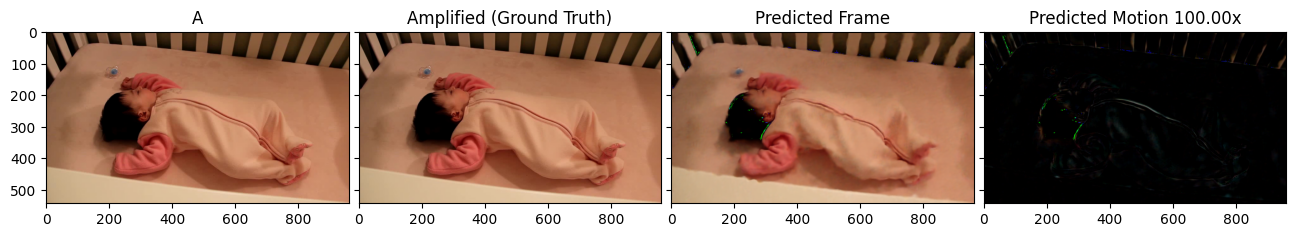

In [9]:
viz.show_pred(frame_a[0],
          frame_b[0],
          amp_f_tensor,
          pred[0].cpu())

In [5]:
resolutions = \
[
 # (160, 120),
 # (176, 144),
 (320, 240),
 # (352, 288),
 # (416, 240),
 # (640, 360),
 # (640, 480),
 # (800, 448),
 # (800, 600),
 # (960, 544),
 # (1280, 720)
]

In [9]:
for resolution in resolutions:
    print("generating trt model for resolution ", resolution, "...")
    torch.cuda.empty_cache()
    batch_size = (1, 3) + (resolution[1], resolution[0])
    example_input_0 = torch.rand(batch_size, dtype=torch.float32).to(device)
    example_input_1 = torch.rand(batch_size, dtype=torch.float32).to(device)
    example_input_2 = torch.full((1, 1), 5, dtype=torch.float32).to(device)
    inputs = [example_input_0, example_input_1, example_input_2]

    model_traced = torch.jit.trace(m, (example_input_0, example_input_1, example_input_2))

    torch.cuda.empty_cache()
    trt_model_fp32 = torch_tensorrt.ts.compile(model_traced, inputs = inputs,
    enabled_precisions = torch.float32, # Run with FP32
    workspace_size = 1 << 22
    )

    torch.jit.save(trt_model_fp32, "model_trt_" + str(resolution[0]) + "_" + str(resolution[1]) + ".ts")
    
    

generating trt model for resolution  (320, 240) ...


In [20]:
# benchmark cuda vs. tensorrt for each resolution

for resolution in resolutions:
    print("benchmark scores for cuda at resolution " + str(resolution[0]) + " x " + str(resolution[1]) + ": ")
    benchmark(m, input_shape=((1, 3) + resolution, (1, 3) + resolution, (1,1)), nruns=100)
    print("benchmark scores for tensorrt at resolution " + str(resolution[0]) + " x " + str(resolution[1]) + ": ")
    benchmark(torch.jit.load("model_trt_" + str(resolution[0]) + "_" + str(resolution[1]) + ".ts"), input_shape=((1, 3) + resolution, (1, 3) + resolution, (1,1)), nruns=100)


benchmark scores for cuda at resolution 160 x 120: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 23.06 ms
Iteration 20/100, ave batch time 23.74 ms
Iteration 30/100, ave batch time 24.42 ms
Iteration 40/100, ave batch time 24.45 ms
Iteration 50/100, ave batch time 24.57 ms
Iteration 60/100, ave batch time 24.54 ms
Iteration 70/100, ave batch time 24.70 ms
Iteration 80/100, ave batch time 24.67 ms
Iteration 90/100, ave batch time 24.65 ms
Iteration 100/100, ave batch time 24.70 ms
Input shape: ((1, 3, 160, 120), (1, 3, 160, 120), (1, 1))
Average batch time: 24.70 ms
benchmark scores for tensorrt at resolution 160 x 120: 


Warm up ...
Start timing ...
Iteration 10/100, ave batch time 16.66 ms
Iteration 20/100, ave batch time 17.72 ms
Iteration 30/100, ave batch time 20.21 ms
Iteration 40/100, ave batch time 19.63 ms
Iteration 50/100, ave batch time 19.51 ms
Iteration 60/100, ave batch time 19.20 ms
Iteration 70/100, ave batch time 19.11 ms
Iteration 80/100, ave batch time 18.95 ms
Iteration 90/100, ave batch time 18.94 ms
Iteration 100/100, ave batch time 18.72 ms
Input shape: ((1, 3, 160, 120), (1, 3, 160, 120), (1, 1))
Average batch time: 18.72 ms
benchmark scores for cuda at resolution 176 x 144: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 30.14 ms
Iteration 20/100, ave batch time 31.14 ms
Iteration 30/100, ave batch time 30.74 ms
Iteration 40/100, ave batch time 30.72 ms
Iteration 50/100, ave batch time 30.85 ms
Iteration 60/100, ave batch time 30.83 ms
Iteration 70/100, ave batch time 30.67 ms
Iteration 80/100, ave batch time 30.62 ms
Iteration 90/100, ave batch time 30.67 ms
Iter

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 29.99 ms
Iteration 20/100, ave batch time 26.76 ms
Iteration 30/100, ave batch time 25.88 ms
Iteration 40/100, ave batch time 25.53 ms
Iteration 50/100, ave batch time 25.17 ms
Iteration 60/100, ave batch time 25.26 ms
Iteration 70/100, ave batch time 25.16 ms
Iteration 80/100, ave batch time 25.13 ms
Iteration 90/100, ave batch time 25.22 ms
Iteration 100/100, ave batch time 25.64 ms
Input shape: ((1, 3, 176, 144), (1, 3, 176, 144), (1, 1))
Average batch time: 25.64 ms
benchmark scores for cuda at resolution 320 x 240: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 81.13 ms
Iteration 20/100, ave batch time 78.38 ms
Iteration 30/100, ave batch time 77.85 ms
Iteration 40/100, ave batch time 77.45 ms
Iteration 50/100, ave batch time 77.19 ms
Iteration 60/100, ave batch time 76.98 ms
Iteration 70/100, ave batch time 78.93 ms
Iteration 80/100, ave batch time 78.31 ms
Iteration 90/100, ave batch time 79.23 ms
Iter

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 61.03 ms
Iteration 20/100, ave batch time 59.56 ms
Iteration 30/100, ave batch time 58.57 ms
Iteration 40/100, ave batch time 58.67 ms
Iteration 50/100, ave batch time 60.22 ms
Iteration 60/100, ave batch time 59.86 ms
Iteration 70/100, ave batch time 59.62 ms
Iteration 80/100, ave batch time 60.46 ms
Iteration 90/100, ave batch time 60.10 ms
Iteration 100/100, ave batch time 60.66 ms
Input shape: ((1, 3, 320, 240), (1, 3, 320, 240), (1, 1))
Average batch time: 60.66 ms
benchmark scores for cuda at resolution 352 x 288: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 108.53 ms
Iteration 20/100, ave batch time 114.87 ms
Iteration 30/100, ave batch time 110.03 ms
Iteration 40/100, ave batch time 108.04 ms
Iteration 50/100, ave batch time 106.71 ms
Iteration 60/100, ave batch time 106.07 ms
Iteration 70/100, ave batch time 105.69 ms
Iteration 80/100, ave batch time 105.19 ms
Iteration 90/100, ave batch time 105.3

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 73.52 ms
Iteration 20/100, ave batch time 82.78 ms
Iteration 30/100, ave batch time 79.82 ms
Iteration 40/100, ave batch time 78.05 ms
Iteration 50/100, ave batch time 76.80 ms
Iteration 60/100, ave batch time 77.27 ms
Iteration 70/100, ave batch time 77.00 ms
Iteration 80/100, ave batch time 76.51 ms
Iteration 90/100, ave batch time 76.00 ms
Iteration 100/100, ave batch time 75.86 ms
Input shape: ((1, 3, 352, 288), (1, 3, 352, 288), (1, 1))
Average batch time: 75.86 ms
benchmark scores for cuda at resolution 416 x 240: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 97.61 ms
Iteration 20/100, ave batch time 98.86 ms
Iteration 30/100, ave batch time 98.81 ms
Iteration 40/100, ave batch time 100.04 ms
Iteration 50/100, ave batch time 100.45 ms
Iteration 60/100, ave batch time 100.20 ms
Iteration 70/100, ave batch time 99.73 ms
Iteration 80/100, ave batch time 99.65 ms
Iteration 90/100, ave batch time 99.62 ms
I

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 70.52 ms
Iteration 20/100, ave batch time 71.75 ms
Iteration 30/100, ave batch time 71.43 ms
Iteration 40/100, ave batch time 70.98 ms
Iteration 50/100, ave batch time 71.22 ms
Iteration 60/100, ave batch time 71.03 ms
Iteration 70/100, ave batch time 70.92 ms
Iteration 80/100, ave batch time 71.06 ms
Iteration 90/100, ave batch time 70.97 ms
Iteration 100/100, ave batch time 71.10 ms
Input shape: ((1, 3, 416, 240), (1, 3, 416, 240), (1, 1))
Average batch time: 71.10 ms
benchmark scores for cuda at resolution 640 x 360: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 227.29 ms
Iteration 20/100, ave batch time 228.97 ms
Iteration 30/100, ave batch time 231.81 ms
Iteration 40/100, ave batch time 234.73 ms
Iteration 50/100, ave batch time 231.41 ms
Iteration 60/100, ave batch time 229.18 ms
Iteration 70/100, ave batch time 227.51 ms
Iteration 80/100, ave batch time 227.06 ms
Iteration 90/100, ave batch time 227.7

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 158.62 ms
Iteration 20/100, ave batch time 157.97 ms
Iteration 30/100, ave batch time 158.02 ms
Iteration 40/100, ave batch time 158.04 ms
Iteration 50/100, ave batch time 157.91 ms
Iteration 60/100, ave batch time 158.23 ms
Iteration 70/100, ave batch time 158.15 ms
Iteration 80/100, ave batch time 158.04 ms
Iteration 90/100, ave batch time 157.95 ms
Iteration 100/100, ave batch time 158.04 ms
Input shape: ((1, 3, 640, 360), (1, 3, 640, 360), (1, 1))
Average batch time: 158.04 ms
benchmark scores for cuda at resolution 640 x 480: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 277.28 ms
Iteration 20/100, ave batch time 280.71 ms
Iteration 30/100, ave batch time 280.14 ms
Iteration 40/100, ave batch time 280.48 ms
Iteration 50/100, ave batch time 280.66 ms
Iteration 60/100, ave batch time 280.66 ms
Iteration 70/100, ave batch time 280.96 ms
Iteration 80/100, ave batch time 284.02 ms
Iteration 90/100, ave batch

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 205.19 ms
Iteration 20/100, ave batch time 204.36 ms
Iteration 30/100, ave batch time 203.80 ms
Iteration 40/100, ave batch time 203.70 ms
Iteration 50/100, ave batch time 203.71 ms
Iteration 60/100, ave batch time 203.43 ms
Iteration 70/100, ave batch time 203.21 ms
Iteration 80/100, ave batch time 203.24 ms
Iteration 90/100, ave batch time 203.24 ms
Iteration 100/100, ave batch time 203.38 ms
Input shape: ((1, 3, 640, 480), (1, 3, 640, 480), (1, 1))
Average batch time: 203.38 ms
benchmark scores for cuda at resolution 800 x 448: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 323.93 ms
Iteration 20/100, ave batch time 336.44 ms
Iteration 30/100, ave batch time 335.28 ms
Iteration 40/100, ave batch time 334.04 ms
Iteration 50/100, ave batch time 343.81 ms
Iteration 60/100, ave batch time 347.74 ms
Iteration 70/100, ave batch time 351.00 ms
Iteration 80/100, ave batch time 350.30 ms
Iteration 90/100, ave batch

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 238.79 ms
Iteration 20/100, ave batch time 236.81 ms
Iteration 30/100, ave batch time 237.28 ms
Iteration 40/100, ave batch time 237.83 ms
Iteration 50/100, ave batch time 237.49 ms
Iteration 60/100, ave batch time 237.10 ms
Iteration 70/100, ave batch time 237.01 ms
Iteration 80/100, ave batch time 237.08 ms
Iteration 90/100, ave batch time 237.21 ms
Iteration 100/100, ave batch time 237.04 ms
Input shape: ((1, 3, 800, 448), (1, 3, 800, 448), (1, 1))
Average batch time: 237.04 ms
benchmark scores for cuda at resolution 800 x 600: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 441.63 ms
Iteration 20/100, ave batch time 440.51 ms
Iteration 30/100, ave batch time 438.45 ms
Iteration 40/100, ave batch time 438.84 ms
Iteration 50/100, ave batch time 439.19 ms
Iteration 60/100, ave batch time 439.19 ms
Iteration 70/100, ave batch time 439.20 ms
Iteration 80/100, ave batch time 439.12 ms
Iteration 90/100, ave batch

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 313.87 ms
Iteration 20/100, ave batch time 315.71 ms
Iteration 30/100, ave batch time 315.73 ms
Iteration 40/100, ave batch time 316.28 ms
Iteration 50/100, ave batch time 316.10 ms
Iteration 60/100, ave batch time 316.18 ms
Iteration 70/100, ave batch time 316.21 ms
Iteration 80/100, ave batch time 316.46 ms
Iteration 90/100, ave batch time 316.46 ms
Iteration 100/100, ave batch time 316.11 ms
Input shape: ((1, 3, 800, 600), (1, 3, 800, 600), (1, 1))
Average batch time: 316.11 ms
benchmark scores for cuda at resolution 960 x 544: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 471.56 ms
Iteration 20/100, ave batch time 470.98 ms
Iteration 30/100, ave batch time 472.28 ms
Iteration 40/100, ave batch time 473.67 ms
Iteration 50/100, ave batch time 472.88 ms
Iteration 60/100, ave batch time 472.52 ms
Iteration 70/100, ave batch time 473.05 ms
Iteration 80/100, ave batch time 473.33 ms
Iteration 90/100, ave batch

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 342.95 ms
Iteration 20/100, ave batch time 340.16 ms
Iteration 30/100, ave batch time 340.85 ms
Iteration 40/100, ave batch time 340.17 ms
Iteration 50/100, ave batch time 340.63 ms
Iteration 60/100, ave batch time 340.76 ms
Iteration 70/100, ave batch time 340.75 ms
Iteration 80/100, ave batch time 341.12 ms
Iteration 90/100, ave batch time 341.05 ms
Iteration 100/100, ave batch time 341.22 ms
Input shape: ((1, 3, 960, 544), (1, 3, 960, 544), (1, 1))
Average batch time: 341.22 ms
benchmark scores for cuda at resolution 1280 x 720: 
Warm up ...
Start timing ...
Iteration 10/100, ave batch time 824.24 ms
Iteration 20/100, ave batch time 832.40 ms
Iteration 30/100, ave batch time 850.83 ms
Iteration 40/100, ave batch time 855.43 ms
Iteration 50/100, ave batch time 869.17 ms
Iteration 60/100, ave batch time 869.14 ms
Iteration 70/100, ave batch time 873.73 ms
Iteration 80/100, ave batch time 870.50 ms
Iteration 90/100, ave batc

ValueError: The provided filename model_trt_1280_720.ts does not exist

In [6]:
example_input_0 = torch.rand((1, 3, 120, 160), dtype=torch.float32).to(device)
example_input_1 = torch.rand((1, 3, 120, 160), dtype=torch.float32).to(device)
example_input_2 = torch.full((1, 1), 5, dtype=torch.float32).to(device)

In [7]:
testing_dataset = [example_input_0, example_input_1, example_input_2]

In [8]:
testing_dataloader = torch.utils.data.DataLoader(
    testing_dataset, batch_size=1, shuffle=False, num_workers=1
)

In [9]:
calibrator = torch_tensorrt.ptq.DataLoaderCalibrator(
    testing_dataloader,
    cache_file="./calibration.cache",
    use_cache=False,
    algo_type=torch_tensorrt.ptq.CalibrationAlgo.ENTROPY_CALIBRATION_2,
    device=torch.device("cuda:0"),
)

In [ ]:
model_traced = torch.jit.trace(m, (example_input_0, example_input_1, example_input_2))

trt_mod = torch_tensorrt.ts.compile(model_traced, inputs=testing_dataset,
                                    enabled_precisions={torch.float, torch.half, torch.int8},
                                    calibrator=calibrator,
                                    device=device)

/home/rhijn/VMM-real-time/motion-magnification-master/deepmag/model.py:63: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  amp = amp_f.reshape(len(amp_f), 1, 1, 1)


In [ ]:
# preprocess two frames and amplification factor
transform = transforms.Compose([
    transforms.ToTensor()
])

frame_a = cv2.imread('example_input_0_120_160.jpg')[...,::-1]
frame_a = torch.unsqueeze(transform(to_pil_image(frame_a)).to(device), 0)
frame_b = cv2.imread('example_input_1_120_160.jpg')[...,::-1]
frame_b = torch.unsqueeze(transform(to_pil_image(frame_b)).to(device), 0)

amplification = 100
amp_f_tensor = torch.tensor(
            [[float(amplification)]], dtype=torch.float, device=device)
frame_a.shape